# First: load imports needed for the project and preparation of the project

In [3]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 230 (delta 0), reused 0 (delta 0), pack-reused 226
Receiving objects: 100% (230/230), 4.31 MiB | 18.10 MiB/s, done.
Resolving deltas: 100% (139/139), done.
/content/Bsc_Thesis
/content


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import datetime
import statistics
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla P100-PCIE-16GB


In [5]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.6
PyTorch: 1.11.0+cu113
Sklearn: 1.0.2
seaborn: 0.11.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [36]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the previous value).

In [37]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [8]:
print_data = False

if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [9]:
# Set to True to print the graphs

print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [10]:
# We print some graphs showing the density distribution of every feature

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [11]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [12]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [13]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very dofferent. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [14]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [15]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 873.81it/s]


In [16]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1418.76it/s]


In [17]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1047.12it/s]


In [18]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [19]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [20]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


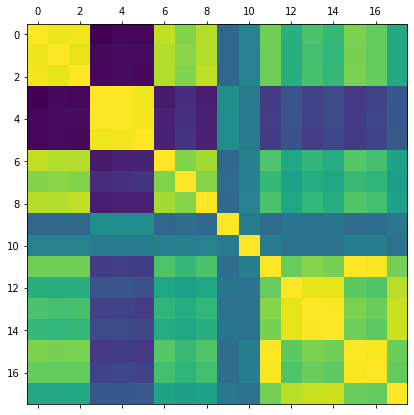

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810274, 0.16335739298653476, 0.07511546472382995, 0.054921627068028424, 0.05390616867076577, 0.04952232661739343, 0.022486349463995598, 0.013932731902136385, 0.012792662672300325, 0.009829012007199104, 0.004024926426955747, 0.002893959610103366, 0.002163271201445878, 0.001741116222641519, 0.0006928432299862775, 0.00021826337426103455, 0.00023351820917083064, 0.0004035851322244031]


In [21]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Correlation between features

In [22]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = np.corrcoef(dataset_norm[i], dataset_norm[j])
    if i != j:
      correlations.append(abs(correlation[0][1]))
      feature.append(abs(correlation[0][1]))
      print(correlation[0][1])
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.9530638927686161
Correlation between PLN1 and PLN3
0.9606664987977857
Correlation between PLN1 and ULL1
-0.7274016376341783
Correlation between PLN1 and ULL2
-0.6955282277514698
Correlation between PLN1 and ULL3
-0.7030835410050382
Correlation between PLN1 and COS_PHI1
0.8410401295195357
Correlation between PLN1 and COS_PHI2
0.6731338062873107
Correlation between PLN1 and COS_PHI3
0.8122370309192153
Correlation between PLN1 and FREQ
-0.1545159794969928
Correlation between PLN1 and RC_DC
0.041447902380906114
Correlation between PLN1 and RC_AC
0.6311099014117805
Correlation between PLN1 and RC_50Hz
0.3688113546135114
Correlation between PLN1 and RC_150Hz
0.5078743784519385
Correlation between PLN1 and RC_<100Hz
0.4309325330867657
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453892
Correlation between PLN1 and RC_>1kHz
0.5928797475823842
Correlation between PLN1 and RC_>10kHz
0.31619183414655355
Mean of PLN1 c

In [23]:
for i in range(len(matrix)):
  print(matrix[i])

[0.9530638927686161, 0.9606664987977857, 0.7274016376341783, 0.6955282277514698, 0.7030835410050382, 0.8410401295195357, 0.6731338062873107, 0.8122370309192153, 0.1545159794969928, 0.041447902380906114, 0.6311099014117805, 0.3688113546135114, 0.5078743784519385, 0.4309325330867657, 0.6585953463453892, 0.5928797475823842, 0.31619183414655355]
[0.9530638927686161, 0.9452605980705139, 0.6920070109902812, 0.6704566233203503, 0.6734582119423186, 0.7986365971843635, 0.7023352006830498, 0.8038123821731546, 0.14213527867385364, 0.039207762733898144, 0.6232451337648502, 0.35899547217519356, 0.4908468912124751, 0.4172313931163452, 0.6488235868701706, 0.5891663952522229, 0.31188438312240335]
[0.9606664987977857, 0.9452605980705139, 0.7002177438968478, 0.6722798995076359, 0.6821156558367119, 0.8022338627218534, 0.6694582338358985, 0.831379706888533, 0.14967487104652202, 0.04088450891644734, 0.6281657734892854, 0.36563522876627164, 0.4989635979541192, 0.423953449978989, 0.653923668551288, 0.5911138

# Preparation Training and Test set

Once the dataset is prepared, make batches of data,put them togheter in an array and split them into train and test sets.
After looking through the dataset and the features, i decided to takeonly the values with a timestap of a weekday between 4:00 and 19:30. In many of the features in the interval outside those timestamps there i only noise, which can be a sign that the machine is off in that time interval.

In [24]:
def create_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=64,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=64,
      shuffle=True
  )

  return loader_train, loader_test

In [25]:
loader_train, loader_test = create_dataloaders(dataset_norm)

100%|██████████| 63359/63359 [00:21<00:00, 2888.37it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




In [26]:
def create_sequece_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one sequence of 30 measures (18 features) and target are the next sequence of 30 
  # measures (18 features)). When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    target = np.array(dataset_norm.iloc[i+30:i+60, 1:])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=30,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=30,
      shuffle=True
  )

  return loader_train, loader_test, training_data, training_target

In [27]:
loader_train_seq, loader_test_seq, training_data_seq, training_target_seq = create_sequece_dataloaders(dataset_norm)

100%|██████████| 63300/63300 [00:20<00:00, 3093.08it/s]


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [26]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train_seq:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test_seq:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.74438670385882
Standard deviation Loss of baselinemodel:  0.07718345182389953


Test set
Mean Loss of baselinemodel:  0.7505493212085199
Standard deviation Loss of baselinemodel:  0.07665549661385343




# Train a simple Feed Forward Neural Network as a baseline model

I trained a simple FFN Network to have a second baseline model. The final model training should have also a better performance than this FFN.

In [27]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 640)
        self.linear3 = nn.Linear(640, 180)
        self.linear4 = nn.Linear(180, D_out)

        self.relu = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return self.linear4(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [28]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.4737903182420934
Standard deviation Loss of baselinemodel:  0.08824692400678744


Test set
Mean Loss of baselinemodel:  0.4659305645359887
Standard deviation Loss of baselinemodel:  0.08625880439436642




In [29]:
n_epochs = 200
lr=0.01

# Create model FFN instance
model_FFN_whole = ANN_relu(18, 18).to(device)
print(model_FFN_whole)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN_whole.parameters(), lr=lr)


train_FFN = False

params_not_trained_whole = model_FFN_whole.parameters()

if train_FFN is True:
  trained_model_FFN_whole , train_losses_whole, test_losses_whole = train(model_FFN_whole, criterion, optimizer_whole, loader_train, loader_test, n_epochs)


ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [30]:
print(model_FFN_whole)

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [31]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_whole))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_whole], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_whole], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [32]:
if train_FFN is True:
  results = torch.Tensor(1, 30, 18).to(device)
  with torch.no_grad():
    trained_model_FFN_whole.train()
    count = 0
    for i in tqdm(training_data_seq):
      batch_result = torch.Tensor(1, 18).to(device)
      new = i[0].unsqueeze(0)

      for j in range(30):
        output = trained_model_FFN_whole(new)
        new = output
        if j == 0:
          batch_result = output
        else:
          batch_result = torch.cat((batch_result, output), 0)

      if count == 0:
        results = batch_result.unsqueeze(0)
      else:
        results = torch.cat((results, batch_result.unsqueeze(0)), 0)
      
      count += 1


In [33]:
if train_FFN is True:
  criterion = nn.MSELoss()

  losses_train = []

  for i in range(len(results)):
    output = results[i]
    target = training_target_seq[i]
    loss = criterion(output, target)
    losses_train.append(loss.item())

  print("Training set")
  print("Mean Loss of FFN baselinemodel: ", np.mean(losses_train))
  print("Standard deviation Loss of FFN baselinemodel: ", np.std(losses_train))
  print('\n')

  base_line_loss = np.mean(losses_train)

# Conclusions FFN

Training this small, easy FFN have an improvement to the base model in the case that we don't take a sequence of samples but we compare each sample individually.

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).


In [34]:
class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)

    def positional_encoding(self, seq_len: int, dim_model: int, device):

        position_encoding = torch.zeros(seq_len, dim_model)
        for pos in range(seq_len):
          for i in range(0, int(dim_model / 2)):
            position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
            position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

        return position_encoding.to(device)
        
    def forward (self, enc_input, dec_input):
        
        mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + self.positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + self.positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src= src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=mask, memory_mask=None)
        
        return output

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [43]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      target = i[1]

      net_out = model.forward(input, target)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input, torch.zeros(30,30,18).to(device))
        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(test_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input, torch.zeros(30,30,18).to(device))

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

# Train Tranformer Model (SGD)

In [1]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=False)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer, train_losses_1, test_losses_1 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

NameError: ignored

In [2]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [base_line_loss for i in range(len(train_losses_1))]
  ax.plot(baseline, label= 'Baseline model')


  ax.plot([np.mean(i) for i in train_losses_1], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()


  

NameError: ignored

# Train Transformer (ADAM)

In [ ]:
start_time = datetime.now()

# Initialize Transformer Model and Optimizer

continue_training = False

if continue_training is False:
  model_transformer_Adam = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=False)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.Adam(model_transformer_Adam.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')


train_transformer = True

if train_transformer is True:
  trained_model_transformer_Adam, train_losses_2, test_losses_2 = training_transformer(
      model= model_transformer_Adam, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.81it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.59it/s]



Current Mean loss Train Set:  0.07907909656109277

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.70it/s]



Current Mean loss Test Set:  0.0793916047043145


Epoch: 2 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.88it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.93it/s]



Current Mean loss Train Set:  0.06920029434241579

Test with test set


100%|██████████| 211/211 [00:01<00:00, 119.79it/s]



Current Mean loss Test Set:  0.06967102902195466


Epoch: 3 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.76it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 112.55it/s]



Current Mean loss Train Set:  0.06193451112182345

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.54it/s]



Current Mean loss Test Set:  0.062014156661186176


Epoch: 4 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.20it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 112.24it/s]



Current Mean loss Train Set:  0.05899928233980065

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.91it/s]



Current Mean loss Test Set:  0.05946175874127031


Epoch: 5 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.33it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.87it/s]



Current Mean loss Train Set:  0.05605663732282735

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.89it/s]



Current Mean loss Test Set:  0.056425318898747884


Epoch: 6 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.16it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.89it/s]



Current Mean loss Train Set:  0.054207449823052964

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.06it/s]



Current Mean loss Test Set:  0.05425179197113096


Epoch: 7 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.12it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.92it/s]



Current Mean loss Train Set:  0.055352536932991456

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.24it/s]



Current Mean loss Test Set:  0.05538397217036989


Epoch: 8 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.49it/s]



Current Mean loss Train Set:  0.05607697302539327

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.92it/s]



Current Mean loss Test Set:  0.05592284180329874


Epoch: 9 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.80it/s]



Current Mean loss Train Set:  0.052465174587471915

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.57it/s]



Current Mean loss Test Set:  0.05267699224371198


Epoch: 10 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.92it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.10it/s]



Current Mean loss Train Set:  0.05670719847510745

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.97it/s]



Current Mean loss Test Set:  0.056546796642914766


Epoch: 11 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.20it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.40it/s]



Current Mean loss Train Set:  0.05603432857586937

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.86it/s]



Current Mean loss Test Set:  0.05623909066568054


Epoch: 12 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.03it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.10it/s]



Current Mean loss Train Set:  0.05687738063226818

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.23it/s]



Current Mean loss Test Set:  0.05670107390855161


Epoch: 13 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.91it/s]



Current Mean loss Train Set:  0.05270180879567817

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.92it/s]



Current Mean loss Test Set:  0.05334810965575313


Epoch: 14 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.91it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.12it/s]



Current Mean loss Train Set:  0.053300877881009304

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.26it/s]



Current Mean loss Test Set:  0.053235053821903834


Epoch: 15 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.15it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.74it/s]



Current Mean loss Train Set:  0.053156177162645424

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.06it/s]



Current Mean loss Test Set:  0.0531893772518889


Epoch: 16 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.17it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.14it/s]



Current Mean loss Train Set:  0.05414570488031756

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.58it/s]



Current Mean loss Test Set:  0.0541035292484749


Epoch: 17 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.24it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.08it/s]



Current Mean loss Train Set:  0.05387236775654815

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.00it/s]



Current Mean loss Test Set:  0.05377509902226981


Epoch: 18 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.26it/s]



Current Mean loss Train Set:  0.05478301223734293

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.17it/s]



Current Mean loss Test Set:  0.05492482999984122


Epoch: 19 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.04it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.16it/s]



Current Mean loss Train Set:  0.051825793756229935

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.46it/s]



Current Mean loss Test Set:  0.051783185787675504


Epoch: 20 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.03it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.53it/s]



Current Mean loss Train Set:  0.056254885297243123

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.32it/s]



Current Mean loss Test Set:  0.056481942534446716


Epoch: 21 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.98it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.36it/s]



Current Mean loss Train Set:  0.05225802192747938

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.44it/s]



Current Mean loss Test Set:  0.052490391278577644


Epoch: 22 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.17it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.16it/s]



Current Mean loss Train Set:  0.05667603560863136

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.45it/s]



Current Mean loss Test Set:  0.05724481989351494


Epoch: 23 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.15it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.83it/s]



Current Mean loss Train Set:  0.05249085574420174

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.99it/s]



Current Mean loss Test Set:  0.05260771039820395


Epoch: 24 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.26it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.81it/s]



Current Mean loss Train Set:  0.05116039632538578

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.36it/s]



Current Mean loss Test Set:  0.051566795759362065


Epoch: 25 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.52it/s]



Current Mean loss Train Set:  0.055248205132660835

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.18it/s]



Current Mean loss Test Set:  0.05588059411582789


Epoch: 26 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.35it/s]



Current Mean loss Train Set:  0.052973694391175906

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.18it/s]



Current Mean loss Test Set:  0.05371839369501548


Epoch: 27 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.35it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.44it/s]



Current Mean loss Train Set:  0.05207212209375894

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.35it/s]



Current Mean loss Test Set:  0.05231944676400361


Epoch: 28 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.73it/s]



Current Mean loss Train Set:  0.0532344720969315

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.67it/s]



Current Mean loss Test Set:  0.05365389765580118


Epoch: 29 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.20it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.65it/s]



Current Mean loss Train Set:  0.05317922681570053

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.71it/s]



Current Mean loss Test Set:  0.05320457128975629


Epoch: 30 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.06it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.77it/s]



Current Mean loss Train Set:  0.05148646102363873

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.49it/s]



Current Mean loss Test Set:  0.05161889061614235


Epoch: 31 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.22it/s]



Current Mean loss Train Set:  0.053707699169291516

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.91it/s]



Current Mean loss Test Set:  0.05447766845118943


Epoch: 32 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.22it/s]



Current Mean loss Train Set:  0.05998415490313227

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.99it/s]



Current Mean loss Test Set:  0.05994970261415034


Epoch: 33 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.37it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.24it/s]



Current Mean loss Train Set:  0.05190992507477413

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.84it/s]



Current Mean loss Test Set:  0.05272056679660675


Epoch: 34 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.32it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.72it/s]



Current Mean loss Train Set:  0.05549038620395934

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.62it/s]



Current Mean loss Test Set:  0.055789342794514384


Epoch: 35 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.76it/s]



Current Mean loss Train Set:  0.05432128248684277

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.49it/s]



Current Mean loss Test Set:  0.05487551029895154


Epoch: 36 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.60it/s]



Current Mean loss Train Set:  0.055950257195460915

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.80it/s]



Current Mean loss Test Set:  0.056113274918065816


Epoch: 37 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.92it/s]



Current Mean loss Train Set:  0.0576312398364382

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.63it/s]



Current Mean loss Test Set:  0.058010136523235466


Epoch: 38 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.44it/s]



Current Mean loss Train Set:  0.055925190435029005

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.20it/s]



Current Mean loss Test Set:  0.05615710839629173


Epoch: 39 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.11it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.09it/s]



Current Mean loss Train Set:  0.05156732536558103

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.54it/s]



Current Mean loss Test Set:  0.05188762943891553


Epoch: 40 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.16it/s]



Current Mean loss Train Set:  0.05265499353546133

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.83it/s]



Current Mean loss Test Set:  0.053077526478829545


Epoch: 41 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.15it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.99it/s]



Current Mean loss Train Set:  0.05317386230448944

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.20it/s]



Current Mean loss Test Set:  0.053533556001587504


Epoch: 42 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.09it/s]



Current Mean loss Train Set:  0.0543375282885292

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.65it/s]



Current Mean loss Test Set:  0.054740181183928


Epoch: 43 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.40it/s]



Current Mean loss Train Set:  0.05265607370584497

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.77it/s]



Current Mean loss Test Set:  0.05293965131326874


Epoch: 44 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.68it/s]



Current Mean loss Train Set:  0.05511317595549167

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.10it/s]



Current Mean loss Test Set:  0.05552157600767805


Epoch: 45 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.33it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.13it/s]



Current Mean loss Train Set:  0.05233093399187651

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.56it/s]



Current Mean loss Test Set:  0.052769231949866664


Epoch: 46 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.11it/s]



Current Mean loss Train Set:  0.051957816018940214

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.50it/s]



Current Mean loss Test Set:  0.05229449208596306


Epoch: 47 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.13it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.38it/s]



Current Mean loss Train Set:  0.05221179410768158

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.66it/s]



Current Mean loss Test Set:  0.05254368561704012


Epoch: 48 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.16it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.58it/s]



Current Mean loss Train Set:  0.056190435824157565

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.18it/s]



Current Mean loss Test Set:  0.05621805499303397


Epoch: 49 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.88it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.47it/s]



Current Mean loss Train Set:  0.05349202307157921

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.28it/s]



Current Mean loss Test Set:  0.05366608138544864


Epoch: 50 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.46it/s]



Current Mean loss Train Set:  0.054350483927163656

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.11it/s]



Current Mean loss Test Set:  0.05471686099024745


Epoch: 51 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.03it/s]



Current Mean loss Train Set:  0.06072058146912654

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.29it/s]



Current Mean loss Test Set:  0.06110253866532402


Epoch: 52 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.19it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.22it/s]



Current Mean loss Train Set:  0.05430757506049703

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.52it/s]



Current Mean loss Test Set:  0.05462906237744607


Epoch: 53 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.24it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.25it/s]



Current Mean loss Train Set:  0.051850927455165376

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.47it/s]



Current Mean loss Test Set:  0.05210443790913758


Epoch: 54 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.79it/s]



Current Mean loss Train Set:  0.05431807374855353

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.41it/s]



Current Mean loss Test Set:  0.05480119953223314


Epoch: 55 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.10it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.12it/s]



Current Mean loss Train Set:  0.05575814686633211

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.43it/s]



Current Mean loss Test Set:  0.05590227122696655


Epoch: 56 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.12it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.24it/s]



Current Mean loss Train Set:  0.05562889482776952

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.27it/s]



Current Mean loss Test Set:  0.05621131424796525


Epoch: 57 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.16it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.36it/s]



Current Mean loss Train Set:  0.057617235909156767

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.20it/s]



Current Mean loss Test Set:  0.057821798575291704


Epoch: 58 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.05it/s]



Current Mean loss Train Set:  0.05280989229192603

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.61it/s]



Current Mean loss Test Set:  0.053034951054089445


Epoch: 59 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.53it/s]



Current Mean loss Train Set:  0.050237914888662

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.64it/s]



Current Mean loss Test Set:  0.05028787634878362


Epoch: 60 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.17it/s]



Current Mean loss Train Set:  0.051250249522102075

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.41it/s]



Current Mean loss Test Set:  0.05179676752519834


Epoch: 61 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.93it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.52it/s]



Current Mean loss Train Set:  0.05593523291528633

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.31it/s]



Current Mean loss Test Set:  0.056222403289582494


Epoch: 62 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.12it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.56it/s]



Current Mean loss Train Set:  0.056233788204387715

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.22it/s]



Current Mean loss Test Set:  0.05674350782522658


Epoch: 63 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.90it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.45it/s]



Current Mean loss Train Set:  0.054581706627434404

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.51it/s]



Current Mean loss Test Set:  0.0547710926717774


Epoch: 64 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.42it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.62it/s]



Current Mean loss Train Set:  0.05805258816593631

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.06it/s]



Current Mean loss Test Set:  0.0580554577517566


Epoch: 65 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.59it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.57it/s]



Current Mean loss Train Set:  0.052722317509435554

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.32it/s]



Current Mean loss Test Set:  0.053082936624356356


Epoch: 66 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.36it/s]



Current Mean loss Train Set:  0.05545950313346395

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.85it/s]



Current Mean loss Test Set:  0.05593271710649486


Epoch: 67 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.97it/s]



Test with training set


100%|██████████| 1899/1899 [00:17<00:00, 107.20it/s]



Current Mean loss Train Set:  0.06037024059394211

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.03it/s]



Current Mean loss Test Set:  0.06046187116707106


Epoch: 68 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.74it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.66it/s]



Current Mean loss Train Set:  0.0561304810158261

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.61it/s]



Current Mean loss Test Set:  0.05594101256880715


Epoch: 69 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.94it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.92it/s]



Current Mean loss Train Set:  0.05803097690749382

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.43it/s]



Current Mean loss Test Set:  0.05807349158194958


Epoch: 70 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.69it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.95it/s]



Current Mean loss Train Set:  0.051274034076455144

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.10it/s]



Current Mean loss Test Set:  0.05145800886984685


Epoch: 71 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.90it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.00it/s]



Current Mean loss Train Set:  0.05347959377389478

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.02it/s]



Current Mean loss Test Set:  0.0535390743217762


Epoch: 72 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.29it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.87it/s]



Current Mean loss Train Set:  0.05263345587357149

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.21it/s]



Current Mean loss Test Set:  0.052929013314264084


Epoch: 73 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.12it/s]



Current Mean loss Train Set:  0.05857975958498796

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.92it/s]



Current Mean loss Test Set:  0.05907249526601832


Epoch: 74 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.24it/s]



Current Mean loss Train Set:  0.05250984724275591

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.10it/s]



Current Mean loss Test Set:  0.052872468404012836


Epoch: 75 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.04it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.27it/s]



Current Mean loss Train Set:  0.055716057641999606

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.21it/s]



Current Mean loss Test Set:  0.05619956657149215


Epoch: 76 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.93it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.36it/s]



Current Mean loss Train Set:  0.05433798626383052

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.24it/s]



Current Mean loss Test Set:  0.0547306953059836


Epoch: 77 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.64it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.47it/s]



Current Mean loss Train Set:  0.053349519515309037

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.00it/s]



Current Mean loss Test Set:  0.0538339751344439


Epoch: 78 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.54it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.48it/s]



Current Mean loss Train Set:  0.054087446073659666

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.64it/s]



Current Mean loss Test Set:  0.0548810035484662


Epoch: 79 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.47it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.98it/s]



Current Mean loss Train Set:  0.05604442941704633

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.56it/s]



Current Mean loss Test Set:  0.056539828460928386


Epoch: 80 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.69it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.51it/s]



Current Mean loss Train Set:  0.05482064954359761

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.29it/s]



Current Mean loss Test Set:  0.05481566795946863


Epoch: 81 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.70it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.11it/s]



Current Mean loss Train Set:  0.0542121491894683

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.92it/s]



Current Mean loss Test Set:  0.054171067755227974


Epoch: 82 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.83it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.96it/s]



Current Mean loss Train Set:  0.05271707244193855

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.55it/s]



Current Mean loss Test Set:  0.05326316646913781


Epoch: 83 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.17it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.95it/s]



Current Mean loss Train Set:  0.05568758538360656

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.06it/s]



Current Mean loss Test Set:  0.055816493928432465


Epoch: 84 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.03it/s]



Current Mean loss Train Set:  0.0532057049099146

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.28it/s]



Current Mean loss Test Set:  0.05364880578424693


Epoch: 85 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.02it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.44it/s]



Current Mean loss Train Set:  0.05469916677744907

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.90it/s]



Current Mean loss Test Set:  0.05522060590262096


Epoch: 86 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.36it/s]



Current Mean loss Train Set:  0.05287206339884771

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.36it/s]



Current Mean loss Test Set:  0.053141003518731675


Epoch: 87 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.01it/s]



Current Mean loss Train Set:  0.053788292385037476

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.61it/s]



Current Mean loss Test Set:  0.054070788696055166


Epoch: 88 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.33it/s]



Current Mean loss Train Set:  0.053416641639950656

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.29it/s]



Current Mean loss Test Set:  0.053543851962445474


Epoch: 89 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.64it/s]



Current Mean loss Train Set:  0.053400454076576884

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.59it/s]



Current Mean loss Test Set:  0.05391498400842974


Epoch: 90 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.72it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.19it/s]



Current Mean loss Train Set:  0.055513092330909515

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.31it/s]



Current Mean loss Test Set:  0.05560088318317987


Epoch: 91 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.54it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.43it/s]



Current Mean loss Train Set:  0.05774811162501024

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.20it/s]



Current Mean loss Test Set:  0.057753783672765534


Epoch: 92 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.40it/s]



Current Mean loss Train Set:  0.054493151866036885

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.22it/s]



Current Mean loss Test Set:  0.05484157887185919


Epoch: 93 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.78it/s]



Current Mean loss Train Set:  0.05428973503171487

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.12it/s]



Current Mean loss Test Set:  0.05461508588273943


Epoch: 94 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.88it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.87it/s]



Current Mean loss Train Set:  0.05328612562157155

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.04it/s]



Current Mean loss Test Set:  0.05327195139222236


Epoch: 95 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.88it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.46it/s]



Current Mean loss Train Set:  0.0563249939002132

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.18it/s]



Current Mean loss Test Set:  0.05688985590756787


Epoch: 96 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.96it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.77it/s]



Current Mean loss Train Set:  0.05418519582452273

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.52it/s]



Current Mean loss Test Set:  0.05457238224445361


Epoch: 97 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.56it/s]



Current Mean loss Train Set:  0.05412088886586034

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.87it/s]



Current Mean loss Test Set:  0.05423821766653332


Epoch: 98 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.78it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.20it/s]



Current Mean loss Train Set:  0.051131569935874976

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.47it/s]



Current Mean loss Test Set:  0.051708179009610444


Epoch: 99 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.97it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.07it/s]



Current Mean loss Train Set:  0.05468679422521478

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.02it/s]



Current Mean loss Test Set:  0.05481186392606717


Epoch: 100 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.02it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.48it/s]



Current Mean loss Train Set:  0.05246068379317478

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.54it/s]



Current Mean loss Test Set:  0.05271968637456261


Epoch: 101 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.84it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.65it/s]



Current Mean loss Train Set:  0.05194819573530748

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.19it/s]



Current Mean loss Test Set:  0.052260250629971944


Epoch: 102 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.91it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.75it/s]



Current Mean loss Train Set:  0.05577899830385438

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.33it/s]



Current Mean loss Test Set:  0.05634510458857527


Epoch: 103 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.55it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.76it/s]



Current Mean loss Train Set:  0.05086612625399692

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.46it/s]



Current Mean loss Test Set:  0.05100997830454207


Epoch: 104 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.68it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.57it/s]



Current Mean loss Train Set:  0.05134290374576135

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.74it/s]



Current Mean loss Test Set:  0.05172239782474052


Epoch: 105 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.83it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.25it/s]



Current Mean loss Train Set:  0.0563603727977768

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.46it/s]



Current Mean loss Test Set:  0.056500423699617386


Epoch: 106 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.83it/s]



Current Mean loss Train Set:  0.054176164028863015

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.84it/s]



Current Mean loss Test Set:  0.0545339990954546


Epoch: 107 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.10it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.42it/s]



Current Mean loss Train Set:  0.05263299301164661

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.74it/s]



Current Mean loss Test Set:  0.05302682527786748


Epoch: 108 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.97it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.23it/s]



Current Mean loss Train Set:  0.05491097775798462

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.73it/s]



Current Mean loss Test Set:  0.05550433336911608


Epoch: 109 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.38it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.65it/s]



Current Mean loss Train Set:  0.054323592725915616

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.89it/s]



Current Mean loss Test Set:  0.054375169260241975


Epoch: 110 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.89it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.63it/s]



Current Mean loss Train Set:  0.05467118391999607

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.34it/s]



Current Mean loss Test Set:  0.05517848596965532


Epoch: 111 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.18it/s]



Current Mean loss Train Set:  0.0549785394502069

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.33it/s]



Current Mean loss Test Set:  0.05473087447302601


Epoch: 112 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.89it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.12it/s]



Current Mean loss Train Set:  0.05710621332536878

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.77it/s]



Current Mean loss Test Set:  0.05722944051804136


Epoch: 113 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.29it/s]



Current Mean loss Train Set:  0.05564249635700052

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.30it/s]



Current Mean loss Test Set:  0.055815924930064036


Epoch: 114 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.48it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.29it/s]



Current Mean loss Train Set:  0.05591958416346313

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.93it/s]



Current Mean loss Test Set:  0.055923434318665644


Epoch: 115 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.35it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.27it/s]



Current Mean loss Train Set:  0.05360238891822718

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.50it/s]



Current Mean loss Test Set:  0.054034916816447016


Epoch: 116 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.43it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.40it/s]



Current Mean loss Train Set:  0.057082548457001184

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.48it/s]



Current Mean loss Test Set:  0.05732003177441127


Epoch: 117 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.53it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.42it/s]



Current Mean loss Train Set:  0.05780789703954641

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.42it/s]



Current Mean loss Test Set:  0.05797625634978168


Epoch: 118 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.29it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.28it/s]



Current Mean loss Train Set:  0.05518397331834153

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.48it/s]



Current Mean loss Test Set:  0.055118680989007816


Epoch: 119 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.06it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.93it/s]



Current Mean loss Train Set:  0.05666468129064172

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.35it/s]



Current Mean loss Test Set:  0.05721332703085872


Epoch: 120 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.47it/s]



Current Mean loss Train Set:  0.05898907289042355

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.18it/s]



Current Mean loss Test Set:  0.05932342963761063


Epoch: 121 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.01it/s]



Current Mean loss Train Set:  0.053481626845680454

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.51it/s]



Current Mean loss Test Set:  0.05344003548413091


Epoch: 122 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.53it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.28it/s]



Current Mean loss Train Set:  0.056951193334147325

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.87it/s]



Current Mean loss Test Set:  0.05686940801863987


Epoch: 123 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.46it/s]



Current Mean loss Train Set:  0.059010215042813195

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.22it/s]



Current Mean loss Test Set:  0.05909667481884572


Epoch: 124 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.49it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.51it/s]



Current Mean loss Train Set:  0.0557539259515636

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.90it/s]



Current Mean loss Test Set:  0.05608675833703217


Epoch: 125 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.33it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.22it/s]



Current Mean loss Train Set:  0.05906908159949015

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.59it/s]



Current Mean loss Test Set:  0.0592224609583475


Epoch: 126 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.65it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.93it/s]



Current Mean loss Train Set:  0.058341882550101205

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.90it/s]



Current Mean loss Test Set:  0.05884979942469235


Epoch: 127 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.52it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.59it/s]



Current Mean loss Train Set:  0.05697450094933319

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.73it/s]



Current Mean loss Test Set:  0.05714541444140023


Epoch: 128 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.53it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.52it/s]



Current Mean loss Train Set:  0.056928437462114796

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.71it/s]



Current Mean loss Test Set:  0.056956528610951525


Epoch: 129 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.10it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.78it/s]



Current Mean loss Train Set:  0.055489578344645844

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.39it/s]



Current Mean loss Test Set:  0.05564867307860139


Epoch: 130 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.64it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.62it/s]



Current Mean loss Train Set:  0.054608069901688594

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.08it/s]



Current Mean loss Test Set:  0.05511275376965649


Epoch: 131 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.24it/s]



Current Mean loss Train Set:  0.056106350662725235

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.22it/s]



Current Mean loss Test Set:  0.056205229295232285


Epoch: 132 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.98it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.70it/s]



Current Mean loss Train Set:  0.05558676366989019

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.98it/s]



Current Mean loss Test Set:  0.05577875152936479


Epoch: 133 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.61it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.36it/s]



Current Mean loss Train Set:  0.05550642993463975

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.93it/s]



Current Mean loss Test Set:  0.055340865882934555


Epoch: 134 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.87it/s]



Current Mean loss Train Set:  0.05865121383873207

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.44it/s]



Current Mean loss Test Set:  0.058943671267038276


Epoch: 135 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.60it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.52it/s]



Current Mean loss Train Set:  0.054120920671090256

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.48it/s]



Current Mean loss Test Set:  0.054296351421924564


Epoch: 136 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.44it/s]



Current Mean loss Train Set:  0.05551119867110014

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.75it/s]



Current Mean loss Test Set:  0.05587348101828336


Epoch: 137 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.54it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.92it/s]



Current Mean loss Train Set:  0.05645186990585812

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.78it/s]



Current Mean loss Test Set:  0.05666492633097827


Epoch: 138 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.81it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.11it/s]



Current Mean loss Train Set:  0.05647490813488581

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.39it/s]



Current Mean loss Test Set:  0.05673723768495836


Epoch: 139 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.51it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.68it/s]



Current Mean loss Train Set:  0.0542161891245729

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.49it/s]



Current Mean loss Test Set:  0.054868874462294916


Epoch: 140 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.47it/s]



Current Mean loss Train Set:  0.05791889653080636

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.76it/s]



Current Mean loss Test Set:  0.05819650755321245


Epoch: 141 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.67it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.64it/s]



Current Mean loss Train Set:  0.05431059235339104

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.57it/s]



Current Mean loss Test Set:  0.05463379702720597


Epoch: 142 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.58it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.40it/s]



Current Mean loss Train Set:  0.055327140707022396

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.10it/s]



Current Mean loss Test Set:  0.05561674905331779


Epoch: 143 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.64it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.81it/s]



Current Mean loss Train Set:  0.056792858903693046

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.90it/s]



Current Mean loss Test Set:  0.056803424246785764


Epoch: 144 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.55it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.14it/s]



Current Mean loss Train Set:  0.0615615341861415

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.81it/s]



Current Mean loss Test Set:  0.06187421588394879


Epoch: 145 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.42it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.14it/s]



Current Mean loss Train Set:  0.056924804727330594

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.27it/s]



Current Mean loss Test Set:  0.057895804980496096


Epoch: 146 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.68it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.82it/s]



Current Mean loss Train Set:  0.06434577148900088

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.77it/s]



Current Mean loss Test Set:  0.06439719469202639


Epoch: 147 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.69it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.39it/s]



Current Mean loss Train Set:  0.06087917278767448

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.57it/s]



Current Mean loss Test Set:  0.06118403249795403


Epoch: 148 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.58it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.14it/s]



Current Mean loss Train Set:  0.05665081463020497

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.95it/s]



Current Mean loss Test Set:  0.056974444750219726


Epoch: 149 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.45it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.66it/s]



Current Mean loss Train Set:  0.05649312286235082

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.96it/s]



Current Mean loss Test Set:  0.05648376958630096


Epoch: 150 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.25it/s]



Current Mean loss Train Set:  0.055866368597529324

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.74it/s]



Current Mean loss Test Set:  0.056251624749170094


Epoch: 151 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.29it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.96it/s]



Current Mean loss Train Set:  0.05483239792824859

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.77it/s]



Current Mean loss Test Set:  0.05544879469331972


Epoch: 152 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.13it/s]



Test with training set


100%|██████████| 1899/1899 [00:17<00:00, 110.39it/s]



Current Mean loss Train Set:  0.056799641517572115

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.03it/s]



Current Mean loss Test Set:  0.05693106958863294


Epoch: 153 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.40it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.50it/s]



Current Mean loss Train Set:  0.056281108801508654

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.91it/s]



Current Mean loss Test Set:  0.05647863061012815


Epoch: 154 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.69it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.90it/s]



Current Mean loss Train Set:  0.05392463871715821

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.80it/s]



Current Mean loss Test Set:  0.0541816463437973


Epoch: 155 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.93it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.94it/s]



Current Mean loss Train Set:  0.056009717707401076

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.71it/s]



Current Mean loss Test Set:  0.05608761677809801


Epoch: 156 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.69it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.16it/s]



Current Mean loss Train Set:  0.055768758064433106

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.69it/s]



Current Mean loss Test Set:  0.055896473386417636


Epoch: 157 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.72it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.20it/s]



Current Mean loss Train Set:  0.05440297654745075

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.78it/s]



Current Mean loss Test Set:  0.05474417804965476


Epoch: 158 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.67it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.04it/s]



Current Mean loss Train Set:  0.0570578470418113

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.08it/s]



Current Mean loss Test Set:  0.05698637337693106


Epoch: 159 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.57it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.04it/s]



Current Mean loss Train Set:  0.05712387994080861

Test with test set


100%|██████████| 211/211 [00:01<00:00, 110.95it/s]



Current Mean loss Test Set:  0.05714684534129373


Epoch: 160 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 112.83it/s]



Current Mean loss Train Set:  0.05567974233514325

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.36it/s]



Current Mean loss Test Set:  0.055943344247425905


Epoch: 161 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.39it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.30it/s]



Current Mean loss Train Set:  0.06869476210677103

Test with test set


100%|██████████| 211/211 [00:01<00:00, 109.96it/s]



Current Mean loss Test Set:  0.06916335122703941


Epoch: 162 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.37it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.12it/s]



Current Mean loss Train Set:  0.05745156799659345

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.21it/s]



Current Mean loss Test Set:  0.05780267388829123


Epoch: 163 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.55it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.99it/s]



Current Mean loss Train Set:  0.05884730760371013

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.63it/s]



Current Mean loss Test Set:  0.05905154647561611


Epoch: 164 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.93it/s]



Current Mean loss Train Set:  0.055438619593512456

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.78it/s]



Current Mean loss Test Set:  0.05572251234009368


Epoch: 165 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.33it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.34it/s]



Current Mean loss Train Set:  0.05560319839911501

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.03it/s]



Current Mean loss Test Set:  0.05579129346950924


Epoch: 166 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.58it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 112.81it/s]



Current Mean loss Train Set:  0.05516411380654985

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.19it/s]



Current Mean loss Test Set:  0.05564724904666015


Epoch: 167 of 200
Training...


100%|██████████| 1899/1899 [00:49<00:00, 38.52it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.48it/s]



Current Mean loss Train Set:  0.05736737560212079

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.25it/s]



Current Mean loss Test Set:  0.057442306077452064


Epoch: 168 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.15it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.86it/s]



Current Mean loss Train Set:  0.05632332166663718

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.27it/s]



Current Mean loss Test Set:  0.056782248443195606


Epoch: 169 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.57it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.89it/s]



Current Mean loss Train Set:  0.057450788873412095

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.61it/s]



Current Mean loss Test Set:  0.05798703170783147


Epoch: 170 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.51it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.62it/s]



Current Mean loss Train Set:  0.060182998958325754

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.04it/s]



Current Mean loss Test Set:  0.06016616117191541


Epoch: 171 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.30it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.76it/s]



Current Mean loss Train Set:  0.0579600530024765

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.78it/s]



Current Mean loss Test Set:  0.058421450097696476


Epoch: 172 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.38it/s]



Current Mean loss Train Set:  0.055464654323253086

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.14it/s]



Current Mean loss Test Set:  0.05605551798196765


Epoch: 173 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.88it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.93it/s]



Current Mean loss Train Set:  0.05612900169108214

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.95it/s]



Current Mean loss Test Set:  0.056438467001886726


Epoch: 174 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.86it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.15it/s]



Current Mean loss Train Set:  0.0578947126837923

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.42it/s]



Current Mean loss Test Set:  0.05809668130219265


Epoch: 175 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.41it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.09it/s]



Current Mean loss Train Set:  0.058004499146770715

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.60it/s]



Current Mean loss Test Set:  0.05861245627157496


Epoch: 176 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.12it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.27it/s]



Current Mean loss Train Set:  0.055297584691256084

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.08it/s]



Current Mean loss Test Set:  0.05508788496750226


Epoch: 177 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.34it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.76it/s]



Current Mean loss Train Set:  0.05828957717518483

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.21it/s]



Current Mean loss Test Set:  0.058375655563098


Epoch: 178 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.55it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.68it/s]



Current Mean loss Train Set:  0.05943064836333023

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.53it/s]



Current Mean loss Test Set:  0.0594262174767623


Epoch: 179 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.52it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 112.91it/s]



Current Mean loss Train Set:  0.059466305100067215

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.23it/s]



Current Mean loss Test Set:  0.06012579269036297


Epoch: 180 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.42it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.69it/s]



Current Mean loss Train Set:  0.06275486176330332

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.15it/s]



Current Mean loss Test Set:  0.06241898710058199


Epoch: 181 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.39it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.90it/s]



Current Mean loss Train Set:  0.05886639007467732

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.87it/s]



Current Mean loss Test Set:  0.05954320395091699


Epoch: 182 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 39.39it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.67it/s]



Current Mean loss Train Set:  0.059564081227123394

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.58it/s]



Current Mean loss Test Set:  0.05977541119990191


Epoch: 183 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.68it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.27it/s]



Current Mean loss Train Set:  0.06209109652357832

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.68it/s]



Current Mean loss Test Set:  0.06263732850127876


Epoch: 184 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.90it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.66it/s]



Current Mean loss Train Set:  0.05788413914663029

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.60it/s]



Current Mean loss Test Set:  0.05850278381346526


Epoch: 185 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.15it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.61it/s]



Current Mean loss Train Set:  0.058510501163297104

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.45it/s]



Current Mean loss Test Set:  0.05847264012383624


Epoch: 186 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.09it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.92it/s]



Current Mean loss Train Set:  0.05668046851380051

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.92it/s]



Current Mean loss Test Set:  0.05703584212474348


Epoch: 187 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 39.91it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.96it/s]



Current Mean loss Train Set:  0.05740624764691911

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.01it/s]



Current Mean loss Test Set:  0.057435526031453465


Epoch: 188 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.68it/s]



Current Mean loss Train Set:  0.05733764473507755

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.05it/s]



Current Mean loss Test Set:  0.05760544522608061


Epoch: 189 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.64it/s]



Current Mean loss Train Set:  0.05664169766193255

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.94it/s]



Current Mean loss Test Set:  0.056982076175122465


Epoch: 190 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.01it/s]



Current Mean loss Train Set:  0.05764657076744421

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.02it/s]



Current Mean loss Test Set:  0.05790326133441021


Epoch: 191 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.44it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.97it/s]



Current Mean loss Train Set:  0.05746249229563356

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.39it/s]



Current Mean loss Test Set:  0.057627837663578194


Epoch: 192 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.38it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.07it/s]



Current Mean loss Train Set:  0.05543614688940962

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.86it/s]



Current Mean loss Test Set:  0.05549163473725884


Epoch: 193 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.29it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.71it/s]



Current Mean loss Train Set:  0.05769887127731586

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.43it/s]



Current Mean loss Test Set:  0.05782093932207727


Epoch: 194 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.59it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.89it/s]



Current Mean loss Train Set:  0.05605633185098459

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.62it/s]



Current Mean loss Test Set:  0.05647081722862913


Epoch: 195 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.32it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.03it/s]



Current Mean loss Train Set:  0.05997243139102247

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.81it/s]



Current Mean loss Test Set:  0.06034383255441042


Epoch: 196 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.25it/s]



Current Mean loss Train Set:  0.058896884535993003

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.71it/s]



Current Mean loss Test Set:  0.059412576999709504


Epoch: 197 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.40it/s]



Current Mean loss Train Set:  0.06037679832701372

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.92it/s]



Current Mean loss Test Set:  0.06083853355657433


Epoch: 198 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.03it/s]



Current Mean loss Train Set:  0.05825958132406421

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.75it/s]



Current Mean loss Test Set:  0.058728383350852544


Epoch: 199 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.27it/s]



Current Mean loss Train Set:  0.054228307144729135

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.85it/s]



Current Mean loss Test Set:  0.05523417300381367


Epoch: 200 of 200
Training...


100%|██████████| 1899/1899 [00:47<00:00, 40.12it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.58it/s]



Current Mean loss Train Set:  0.05795325180922702

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.40it/s]


Current Mean loss Test Set:  0.05802326612351065


13338055.774 miliseconds


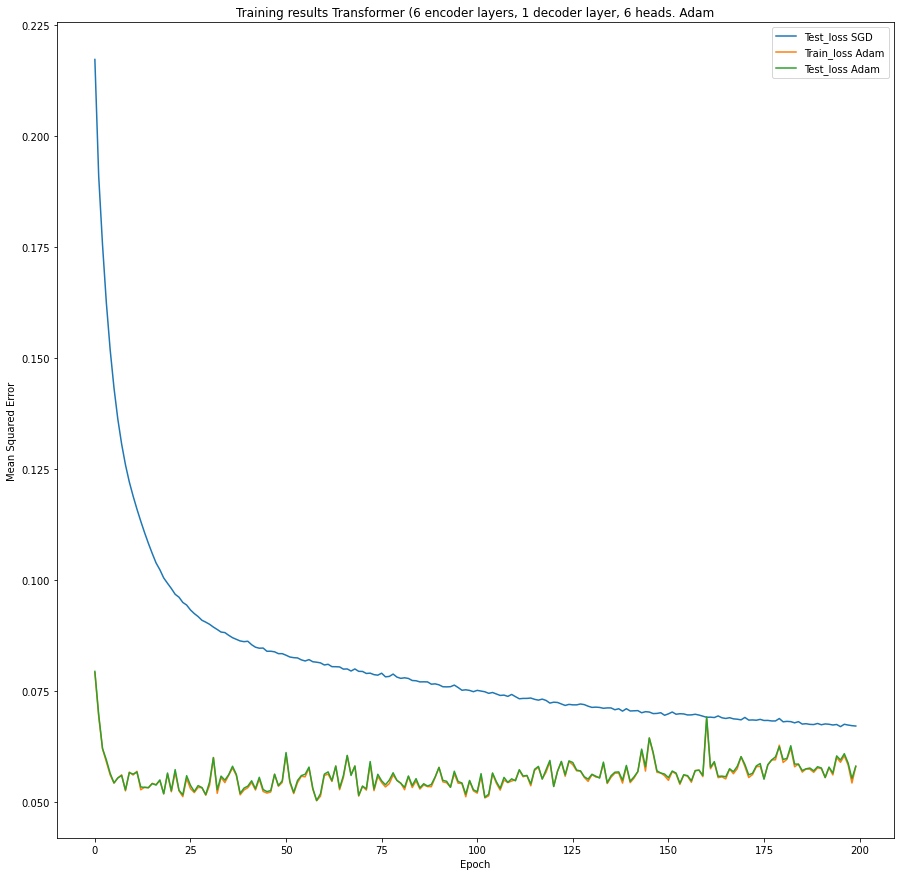

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss SGD')


  ax.plot([np.mean(i) for i in train_losses_2], label= 'Train_loss Adam')
  ax.plot([np.mean(i) for i in test_losses_2], label= 'Test_loss Adam')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. Adam")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# Train Transformer (SGD with momentum)

In [ ]:
start_time = datetime.now()

# Initialize Transformer Model and Optimizer

continue_training = False

if continue_training is False:
  model_transformer_SGD_mom = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=False)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer_SGD_mom.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')


train_transformer = True

if train_transformer is True:
  trained_model_transformer_SGD_mom, train_losses_3, test_losses_3 = training_transformer(
      model= model_transformer_SGD_mom, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.65it/s]



Current Mean loss Train Set:  0.12278719336233872

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.33it/s]



Current Mean loss Test Set:  0.12307199517980007


Epoch: 2 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.46it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.72it/s]



Current Mean loss Train Set:  0.09911356921091465

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.48it/s]



Current Mean loss Test Set:  0.09957150158017733


Epoch: 3 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.54it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.21it/s]



Current Mean loss Train Set:  0.09343446348806066

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.39it/s]



Current Mean loss Test Set:  0.0936384629546466


Epoch: 4 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.19it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.29it/s]



Current Mean loss Train Set:  0.08776335780944806

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.26it/s]



Current Mean loss Test Set:  0.08825473969369703


Epoch: 5 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.51it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 118.06it/s]



Current Mean loss Train Set:  0.08442233770049955

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.82it/s]



Current Mean loss Test Set:  0.08500116062460918


Epoch: 6 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.30it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.82it/s]



Current Mean loss Train Set:  0.0812686717411353

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.73it/s]



Current Mean loss Test Set:  0.0816129470217567


Epoch: 7 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.47it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.68it/s]



Current Mean loss Train Set:  0.08055605938076471

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.33it/s]



Current Mean loss Test Set:  0.08093869781465891


Epoch: 8 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.98it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.66it/s]



Current Mean loss Train Set:  0.07823037487769077

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.90it/s]



Current Mean loss Test Set:  0.07875351983859641


Epoch: 9 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.32it/s]



Current Mean loss Train Set:  0.0769994538954178

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.72it/s]



Current Mean loss Test Set:  0.07731044769145866


Epoch: 10 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.11it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.64it/s]



Current Mean loss Train Set:  0.07581458390818388

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.81it/s]



Current Mean loss Test Set:  0.0761907974090339


Epoch: 11 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.21it/s]



Current Mean loss Train Set:  0.07412602757547579

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.64it/s]



Current Mean loss Test Set:  0.07452130153492728


Epoch: 12 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.81it/s]



Current Mean loss Train Set:  0.07302937162093516

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.40it/s]



Current Mean loss Test Set:  0.07340367869319508


Epoch: 13 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.87it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.87it/s]



Current Mean loss Train Set:  0.07183866531417958

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.07it/s]



Current Mean loss Test Set:  0.07222647618908452


Epoch: 14 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.69it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.43it/s]



Current Mean loss Train Set:  0.0710739739741414

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.52it/s]



Current Mean loss Test Set:  0.07148213636889277


Epoch: 15 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.92it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.33it/s]



Current Mean loss Train Set:  0.07012487685071474

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.79it/s]



Current Mean loss Test Set:  0.07045820676743701


Epoch: 16 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.28it/s]



Current Mean loss Train Set:  0.06928659759936615

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.91it/s]



Current Mean loss Test Set:  0.06960699031067685


Epoch: 17 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.10it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.11it/s]



Current Mean loss Train Set:  0.06814066008941759

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.69it/s]



Current Mean loss Test Set:  0.06843798399254045


Epoch: 18 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.08it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.42it/s]



Current Mean loss Train Set:  0.06802058415688485

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.96it/s]



Current Mean loss Test Set:  0.06844392288211398


Epoch: 19 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.47it/s]



Current Mean loss Train Set:  0.06782709763411349

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.23it/s]



Current Mean loss Test Set:  0.06818785749693618


Epoch: 20 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.97it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.80it/s]



Current Mean loss Train Set:  0.06697043936882068

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.29it/s]



Current Mean loss Test Set:  0.06722159618379381


Epoch: 21 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 118.35it/s]



Current Mean loss Train Set:  0.06636756843739651

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.03it/s]



Current Mean loss Test Set:  0.06670660599713077


Epoch: 22 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.07it/s]



Current Mean loss Train Set:  0.0665416495208523

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.10it/s]



Current Mean loss Test Set:  0.06688579701558109


Epoch: 23 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.33it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.15it/s]



Current Mean loss Train Set:  0.06542369184045493

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.08it/s]



Current Mean loss Test Set:  0.0657916717248929


Epoch: 24 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.80it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.60it/s]



Current Mean loss Train Set:  0.06501292597979166

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.18it/s]



Current Mean loss Test Set:  0.0653613411878805


Epoch: 25 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.75it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.22it/s]



Current Mean loss Train Set:  0.06495728206601564

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.26it/s]



Current Mean loss Test Set:  0.06528582694053085


Epoch: 26 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.56it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.00it/s]



Current Mean loss Train Set:  0.06366377550247407

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.28it/s]



Current Mean loss Test Set:  0.06397773366050698


Epoch: 27 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.80it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.94it/s]



Current Mean loss Train Set:  0.06339052696273383

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.91it/s]



Current Mean loss Test Set:  0.06371212288101702


Epoch: 28 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.95it/s]



Current Mean loss Train Set:  0.06366896302218089

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.79it/s]



Current Mean loss Test Set:  0.06396860966538366


Epoch: 29 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.11it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.74it/s]



Current Mean loss Train Set:  0.0625833809422844

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.17it/s]



Current Mean loss Test Set:  0.06291994877971745


Epoch: 30 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.05it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.38it/s]



Current Mean loss Train Set:  0.06222815727476637

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.56it/s]



Current Mean loss Test Set:  0.06256510447975583


Epoch: 31 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.85it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.79it/s]



Current Mean loss Train Set:  0.06232583794689856

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.06it/s]



Current Mean loss Test Set:  0.06261973563246252


Epoch: 32 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.82it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.38it/s]



Current Mean loss Train Set:  0.061453166252503334

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.29it/s]



Current Mean loss Test Set:  0.06174253336908693


Epoch: 33 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.74it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.14it/s]



Current Mean loss Train Set:  0.06135570419743351

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.74it/s]



Current Mean loss Test Set:  0.0616957314877431


Epoch: 34 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.51it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.98it/s]



Current Mean loss Train Set:  0.0609289244731487

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.81it/s]



Current Mean loss Test Set:  0.06127653851822654


Epoch: 35 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.32it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.62it/s]



Current Mean loss Train Set:  0.0609799825457396

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.97it/s]



Current Mean loss Test Set:  0.06130404759781056


Epoch: 36 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.69it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.48it/s]



Current Mean loss Train Set:  0.060237842312317075

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.08it/s]



Current Mean loss Test Set:  0.06051893126201856


Epoch: 37 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.71it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.52it/s]



Current Mean loss Train Set:  0.06018551359303284

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.51it/s]



Current Mean loss Test Set:  0.06045432946693276


Epoch: 38 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.20it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.14it/s]



Current Mean loss Train Set:  0.06036522349400574

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.14it/s]



Current Mean loss Test Set:  0.06064138141288577


Epoch: 39 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.28it/s]



Current Mean loss Train Set:  0.05979901401835124

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.99it/s]



Current Mean loss Test Set:  0.06004107063768599


Epoch: 40 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.66it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.92it/s]



Current Mean loss Train Set:  0.05899902897788356

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.18it/s]



Current Mean loss Test Set:  0.05927746974249587


Epoch: 41 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.19it/s]



Current Mean loss Train Set:  0.059067085592283144

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.19it/s]



Current Mean loss Test Set:  0.0592915486385472


Epoch: 42 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.75it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.05it/s]



Current Mean loss Train Set:  0.05874486628031184

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.85it/s]



Current Mean loss Test Set:  0.059038139350041395


Epoch: 43 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.70it/s]



Current Mean loss Train Set:  0.05869279544370905

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.61it/s]



Current Mean loss Test Set:  0.05890370923054727


Epoch: 44 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.88it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.87it/s]



Current Mean loss Train Set:  0.05783713359450465

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.91it/s]



Current Mean loss Test Set:  0.05811208441535726


Epoch: 45 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.78it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.68it/s]



Current Mean loss Train Set:  0.05704967099182571

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.90it/s]



Current Mean loss Test Set:  0.05724399369121728


Epoch: 46 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.83it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.52it/s]



Current Mean loss Train Set:  0.056710655513117034

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.98it/s]



Current Mean loss Test Set:  0.05680519399802549


Epoch: 47 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.82it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.86it/s]



Current Mean loss Train Set:  0.05570005470216902

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.15it/s]



Current Mean loss Test Set:  0.055801116036012836


Epoch: 48 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.59it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.40it/s]



Current Mean loss Train Set:  0.05410281695099866

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.83it/s]



Current Mean loss Test Set:  0.054292342179759416


Epoch: 49 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.63it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.74it/s]



Current Mean loss Train Set:  0.053484340888370084

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.29it/s]



Current Mean loss Test Set:  0.05371235088573248


Epoch: 50 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.49it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.20it/s]



Current Mean loss Train Set:  0.0519935358786517

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.37it/s]



Current Mean loss Test Set:  0.05225577071238468


Epoch: 51 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.49it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.11it/s]



Current Mean loss Train Set:  0.05078967536881511

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.15it/s]



Current Mean loss Test Set:  0.05098148457423488


Epoch: 52 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.43it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.58it/s]



Current Mean loss Train Set:  0.04988140866882303

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.58it/s]



Current Mean loss Test Set:  0.05014053033002745


Epoch: 53 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.78it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.21it/s]



Current Mean loss Train Set:  0.04917377998965109

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.66it/s]



Current Mean loss Test Set:  0.04928874343598341


Epoch: 54 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.25it/s]



Current Mean loss Train Set:  0.04875354262646592

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.80it/s]



Current Mean loss Test Set:  0.04896317368541001


Epoch: 55 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.80it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.44it/s]



Current Mean loss Train Set:  0.04822366456528159

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.90it/s]



Current Mean loss Test Set:  0.0483784092969804


Epoch: 56 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.75it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.33it/s]



Current Mean loss Train Set:  0.047254062888887824

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.53it/s]



Current Mean loss Test Set:  0.04741885894423978


Epoch: 57 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.68it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.80it/s]



Current Mean loss Train Set:  0.04687000897513401

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.65it/s]



Current Mean loss Test Set:  0.04701745444776323


Epoch: 58 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.92it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.84it/s]



Current Mean loss Train Set:  0.04668348545935388

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.31it/s]



Current Mean loss Test Set:  0.04691290955160749


Epoch: 59 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.82it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.58it/s]



Current Mean loss Train Set:  0.046360306507501246

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.06it/s]



Current Mean loss Test Set:  0.04661656691917876


Epoch: 60 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.84it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.09it/s]



Current Mean loss Train Set:  0.04561077773261064

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.56it/s]



Current Mean loss Test Set:  0.04568099121947142


Epoch: 61 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.93it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.16it/s]



Current Mean loss Train Set:  0.04551542877735057

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.16it/s]



Current Mean loss Test Set:  0.045788329253547


Epoch: 62 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.47it/s]



Current Mean loss Train Set:  0.045385536678398265

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.79it/s]



Current Mean loss Test Set:  0.045560527663519035


Epoch: 63 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.65it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.33it/s]



Current Mean loss Train Set:  0.0451603932526863

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.92it/s]



Current Mean loss Test Set:  0.04536691542838422


Epoch: 64 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.48it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.93it/s]



Current Mean loss Train Set:  0.04474671635229441

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.17it/s]



Current Mean loss Test Set:  0.04495719221742797


Epoch: 65 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.93it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.04it/s]



Current Mean loss Train Set:  0.04448390220060921

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.09it/s]



Current Mean loss Test Set:  0.04480261887948942


Epoch: 66 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.63it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.06it/s]



Current Mean loss Train Set:  0.04448434639684836

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.53it/s]



Current Mean loss Test Set:  0.04479483953760981


Epoch: 67 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.78it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 117.49it/s]



Current Mean loss Train Set:  0.04425839826821684

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.30it/s]



Current Mean loss Test Set:  0.044397343656321836


Epoch: 68 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.83it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.32it/s]



Current Mean loss Train Set:  0.04412119034648318

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.85it/s]



Current Mean loss Test Set:  0.044354542772069364


Epoch: 69 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.19it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.28it/s]



Current Mean loss Train Set:  0.04359383623911683

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.84it/s]



Current Mean loss Test Set:  0.043794555518935074


Epoch: 70 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.25it/s]



Current Mean loss Train Set:  0.04386116837246001

Test with test set


100%|██████████| 211/211 [00:01<00:00, 118.87it/s]



Current Mean loss Test Set:  0.0439939120722608


Epoch: 71 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.35it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.57it/s]



Current Mean loss Train Set:  0.04347802914400487

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.91it/s]



Current Mean loss Test Set:  0.04367562702976132


Epoch: 72 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.72it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.00it/s]



Current Mean loss Train Set:  0.04334577439493132

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.34it/s]



Current Mean loss Test Set:  0.04354632980415324


Epoch: 73 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.52it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.32it/s]



Current Mean loss Train Set:  0.043232353713133886

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.16it/s]



Current Mean loss Test Set:  0.04343283240864345


Epoch: 74 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.57it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.80it/s]



Current Mean loss Train Set:  0.043276283825272446

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.81it/s]



Current Mean loss Test Set:  0.04356518220068154


Epoch: 75 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.91it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.43it/s]



Current Mean loss Train Set:  0.04333347203469923

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.86it/s]



Current Mean loss Test Set:  0.04351824811567062


Epoch: 76 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.56it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.06it/s]



Current Mean loss Train Set:  0.04271327816499196

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.60it/s]



Current Mean loss Test Set:  0.04298981488351291


Epoch: 77 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.05it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.80it/s]



Current Mean loss Train Set:  0.04267865175350896

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.97it/s]



Current Mean loss Test Set:  0.042921820752569846


Epoch: 78 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.10it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.27it/s]



Current Mean loss Train Set:  0.044026097185662576

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.18it/s]



Current Mean loss Test Set:  0.044332815360683966


Epoch: 79 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 48.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.97it/s]



Current Mean loss Train Set:  0.04260494767258109

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.86it/s]



Current Mean loss Test Set:  0.042833983403811525


Epoch: 80 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.72it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.01it/s]



Current Mean loss Train Set:  0.04268346283449475

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.23it/s]



Current Mean loss Test Set:  0.043040279219571445


Epoch: 81 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.68it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.09it/s]



Current Mean loss Train Set:  0.042402366102683414

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.66it/s]



Current Mean loss Test Set:  0.04276389703684226


Epoch: 82 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.69it/s]



Current Mean loss Train Set:  0.0422696905164514

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.38it/s]



Current Mean loss Test Set:  0.04268280986113853


Epoch: 83 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.88it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.70it/s]



Current Mean loss Train Set:  0.04212780154186089

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.29it/s]



Current Mean loss Test Set:  0.04239301439109854


Epoch: 84 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.68it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.58it/s]



Current Mean loss Train Set:  0.04215877253823119

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.75it/s]



Current Mean loss Test Set:  0.042380022308767126


Epoch: 85 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.41it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.17it/s]



Current Mean loss Train Set:  0.04195914225944128

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.48it/s]



Current Mean loss Test Set:  0.042300423642540996


Epoch: 86 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.35it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.99it/s]



Current Mean loss Train Set:  0.04177442991251755

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.25it/s]



Current Mean loss Test Set:  0.0419832418509428


Epoch: 87 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.69it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.69it/s]



Current Mean loss Train Set:  0.0420175520659058

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.22it/s]



Current Mean loss Test Set:  0.04223000469189402


Epoch: 88 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.46it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.57it/s]



Current Mean loss Train Set:  0.0420053754925822

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.33it/s]



Current Mean loss Test Set:  0.042241935022351865


Epoch: 89 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.41it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.80it/s]



Current Mean loss Train Set:  0.04198878210404787

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.87it/s]



Current Mean loss Test Set:  0.042069380273115575


Epoch: 90 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.26it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.51it/s]



Current Mean loss Train Set:  0.04244703983690878

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.07it/s]



Current Mean loss Test Set:  0.042724393361128904


Epoch: 91 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.35it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.17it/s]



Current Mean loss Train Set:  0.04165737894022854

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.86it/s]



Current Mean loss Test Set:  0.04199178341193504


Epoch: 92 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.87it/s]



Current Mean loss Train Set:  0.04188511611353322

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.44it/s]



Current Mean loss Test Set:  0.04221645602294337


Epoch: 93 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.74it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.48it/s]



Current Mean loss Train Set:  0.041302128620896925

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.99it/s]



Current Mean loss Test Set:  0.041499063725720084


Epoch: 94 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.73it/s]



Current Mean loss Train Set:  0.04138811824822689

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.13it/s]



Current Mean loss Test Set:  0.04157726578767548


Epoch: 95 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.74it/s]



Current Mean loss Train Set:  0.04248087745691488

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.00it/s]



Current Mean loss Test Set:  0.04281317873447427


Epoch: 96 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.03it/s]



Current Mean loss Train Set:  0.041260118758587414

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.49it/s]



Current Mean loss Test Set:  0.04144735803818816


Epoch: 97 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.38it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.16it/s]



Current Mean loss Train Set:  0.0413048734761904

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.80it/s]



Current Mean loss Test Set:  0.041558237975878175


Epoch: 98 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.62it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.66it/s]



Current Mean loss Train Set:  0.04098613366971147

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.88it/s]



Current Mean loss Test Set:  0.04121896389748248


Epoch: 99 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.22it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.82it/s]



Current Mean loss Train Set:  0.04132159157367271

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.95it/s]



Current Mean loss Test Set:  0.041621444587953284


Epoch: 100 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.05it/s]



Current Mean loss Train Set:  0.040934516532859594

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.39it/s]



Current Mean loss Test Set:  0.0411634148138253


Epoch: 101 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.29it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.28it/s]



Current Mean loss Train Set:  0.04107991055148473

Test with test set


100%|██████████| 211/211 [00:01<00:00, 119.30it/s]



Current Mean loss Test Set:  0.041479282354785936


Epoch: 102 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.37it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.69it/s]



Current Mean loss Train Set:  0.04083595775938806

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.15it/s]



Current Mean loss Test Set:  0.04099640380855985


Epoch: 103 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.75it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.74it/s]



Current Mean loss Train Set:  0.040785413917120726

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.55it/s]



Current Mean loss Test Set:  0.041049244579686936


Epoch: 104 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.29it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.54it/s]



Current Mean loss Train Set:  0.040759209228611856

Test with test set


100%|██████████| 211/211 [00:01<00:00, 109.96it/s]



Current Mean loss Test Set:  0.04098424885722133


Epoch: 105 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.03it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.70it/s]



Current Mean loss Train Set:  0.04067652269691747

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.27it/s]



Current Mean loss Test Set:  0.04090817499535061


Epoch: 106 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.78it/s]



Current Mean loss Train Set:  0.04041503767250964

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.44it/s]



Current Mean loss Test Set:  0.04068904246481674


Epoch: 107 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.10it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.75it/s]



Current Mean loss Train Set:  0.04078984551088568

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.64it/s]



Current Mean loss Test Set:  0.041085284397500386


Epoch: 108 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.77it/s]



Current Mean loss Train Set:  0.04041112443454772

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.41it/s]



Current Mean loss Test Set:  0.04072355624659084


Epoch: 109 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.92it/s]



Current Mean loss Train Set:  0.040601418142242766

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.01it/s]



Current Mean loss Test Set:  0.04084988252670279


Epoch: 110 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.39it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.62it/s]



Current Mean loss Train Set:  0.04041704192675215

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.03it/s]



Current Mean loss Test Set:  0.04076204602540387


Epoch: 111 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.58it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.47it/s]



Current Mean loss Train Set:  0.040341734461458875

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.58it/s]



Current Mean loss Test Set:  0.040506389212763706


Epoch: 112 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.78it/s]



Current Mean loss Train Set:  0.040395097643246836

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.04it/s]



Current Mean loss Test Set:  0.0407545173196431


Epoch: 113 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.23it/s]



Current Mean loss Train Set:  0.040723125542023106

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.16it/s]



Current Mean loss Test Set:  0.0408270683810468


Epoch: 114 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.56it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.04it/s]



Current Mean loss Train Set:  0.04022746029191735

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.40it/s]



Current Mean loss Test Set:  0.04052140369516978


Epoch: 115 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.08it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.45it/s]



Current Mean loss Train Set:  0.04198291669822857

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.85it/s]



Current Mean loss Test Set:  0.04210908708308263


Epoch: 116 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.19it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.11it/s]



Current Mean loss Train Set:  0.04053429922009531

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.49it/s]



Current Mean loss Test Set:  0.040671459200540425


Epoch: 117 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.21it/s]



Current Mean loss Train Set:  0.040334783789710095

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.46it/s]



Current Mean loss Test Set:  0.0406406914894756


Epoch: 118 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.50it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.74it/s]



Current Mean loss Train Set:  0.04167220790258924

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.13it/s]



Current Mean loss Test Set:  0.04179120115865181


Epoch: 119 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.03it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.68it/s]



Current Mean loss Train Set:  0.04129073294708451

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.75it/s]



Current Mean loss Test Set:  0.04162309162530571


Epoch: 120 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.57it/s]



Current Mean loss Train Set:  0.0401503249390807

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.36it/s]



Current Mean loss Test Set:  0.0404967320509149


Epoch: 121 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.29it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.38it/s]



Current Mean loss Train Set:  0.04022557676631002

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.54it/s]



Current Mean loss Test Set:  0.040582963446446504


Epoch: 122 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.10it/s]



Current Mean loss Train Set:  0.0401897570574406

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.08it/s]



Current Mean loss Test Set:  0.040437399255226575


Epoch: 123 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.84it/s]



Current Mean loss Train Set:  0.04148126960393157

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.52it/s]



Current Mean loss Test Set:  0.041707944831153226


Epoch: 124 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.24it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.72it/s]



Current Mean loss Train Set:  0.040010102027502416

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.54it/s]



Current Mean loss Test Set:  0.04025862743786726


Epoch: 125 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.18it/s]



Current Mean loss Train Set:  0.039952356768492465

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.39it/s]



Current Mean loss Test Set:  0.040239702142174774


Epoch: 126 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.00it/s]



Current Mean loss Train Set:  0.04013359289088646

Test with test set


100%|██████████| 211/211 [00:01<00:00, 110.85it/s]



Current Mean loss Test Set:  0.04030758448792578


Epoch: 127 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.20it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.09it/s]



Current Mean loss Train Set:  0.039870705196595684

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.16it/s]



Current Mean loss Test Set:  0.040219499522122726


Epoch: 128 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.57it/s]



Current Mean loss Train Set:  0.040000534886636505

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.01it/s]



Current Mean loss Test Set:  0.040215784886860735


Epoch: 129 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.44it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.80it/s]



Current Mean loss Train Set:  0.04075970923260302

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.73it/s]



Current Mean loss Test Set:  0.04101483645667962


Epoch: 130 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.11it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.28it/s]



Current Mean loss Train Set:  0.03973981123682447

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.58it/s]



Current Mean loss Test Set:  0.040010400531345636


Epoch: 131 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.19it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.37it/s]



Current Mean loss Train Set:  0.03970374683876487

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.26it/s]



Current Mean loss Test Set:  0.03986349968478013


Epoch: 132 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.52it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.54it/s]



Current Mean loss Train Set:  0.040103970353480324

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.65it/s]



Current Mean loss Test Set:  0.040308138187886415


Epoch: 133 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.38it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.23it/s]



Current Mean loss Train Set:  0.04001830991704788

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.77it/s]



Current Mean loss Test Set:  0.04019111950144666


Epoch: 134 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.17it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.22it/s]



Current Mean loss Train Set:  0.04075938707640323

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.29it/s]



Current Mean loss Test Set:  0.040779727021170456


Epoch: 135 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.30it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.16it/s]



Current Mean loss Train Set:  0.04052354087302753

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.74it/s]



Current Mean loss Test Set:  0.0408335378684845


Epoch: 136 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.92it/s]



Current Mean loss Train Set:  0.03956300398239718

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.55it/s]



Current Mean loss Test Set:  0.03982940002816831


Epoch: 137 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.87it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 116.41it/s]



Current Mean loss Train Set:  0.03944846391756325

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.34it/s]



Current Mean loss Test Set:  0.03965382851766184


Epoch: 138 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.04it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.55it/s]



Current Mean loss Train Set:  0.039498895472440364

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.52it/s]



Current Mean loss Test Set:  0.03972616822622116


Epoch: 139 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.70it/s]



Current Mean loss Train Set:  0.039696969122298774

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.13it/s]



Current Mean loss Test Set:  0.039926275098917045


Epoch: 140 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.50it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.52it/s]



Current Mean loss Train Set:  0.03926346950201595

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.14it/s]



Current Mean loss Test Set:  0.03944968065838396


Epoch: 141 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.12it/s]



Current Mean loss Train Set:  0.03960253043848631

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.78it/s]



Current Mean loss Test Set:  0.03988962464246422


Epoch: 142 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.80it/s]



Current Mean loss Train Set:  0.039796575118227026

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.22it/s]



Current Mean loss Test Set:  0.040049280679974514


Epoch: 143 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.90it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.01it/s]



Current Mean loss Train Set:  0.039177353116730256

Test with test set


100%|██████████| 211/211 [00:01<00:00, 110.25it/s]



Current Mean loss Test Set:  0.03932566974329722


Epoch: 144 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.06it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.89it/s]



Current Mean loss Train Set:  0.0397959818024818

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.85it/s]



Current Mean loss Test Set:  0.04005908473478674


Epoch: 145 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.32it/s]



Current Mean loss Train Set:  0.03955462034114918

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.40it/s]



Current Mean loss Test Set:  0.03976141754096436


Epoch: 146 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.34it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.12it/s]



Current Mean loss Train Set:  0.03933654561454431

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.75it/s]



Current Mean loss Test Set:  0.03958936025039845


Epoch: 147 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.23it/s]



Current Mean loss Train Set:  0.03921237776154998

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.97it/s]



Current Mean loss Test Set:  0.039514541061003626


Epoch: 148 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.10it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.39it/s]



Current Mean loss Train Set:  0.03903690100563646

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.94it/s]



Current Mean loss Test Set:  0.03921304222955523


Epoch: 149 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.92it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.56it/s]



Current Mean loss Train Set:  0.039107500650518316

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.12it/s]



Current Mean loss Test Set:  0.03934425311560314


Epoch: 150 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.65it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.46it/s]



Current Mean loss Train Set:  0.039539790811853825

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.68it/s]



Current Mean loss Test Set:  0.03969445422079891


Epoch: 151 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.98it/s]



Current Mean loss Train Set:  0.03966375067437743

Test with test set


100%|██████████| 211/211 [00:01<00:00, 110.61it/s]



Current Mean loss Test Set:  0.0397970028998445


Epoch: 152 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.41it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.28it/s]



Current Mean loss Train Set:  0.03961942960194784

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.50it/s]



Current Mean loss Test Set:  0.03984703037940778


Epoch: 153 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.85it/s]



Current Mean loss Train Set:  0.03918139377668727

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.91it/s]



Current Mean loss Test Set:  0.03941211644648376


Epoch: 154 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.98it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.22it/s]



Current Mean loss Train Set:  0.040152135296769365

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.26it/s]



Current Mean loss Test Set:  0.04031411162025838


Epoch: 155 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.04it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.89it/s]



Current Mean loss Train Set:  0.03935430778593625

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.00it/s]



Current Mean loss Test Set:  0.03949073816857067


Epoch: 156 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.97it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.13it/s]



Current Mean loss Train Set:  0.038867529082441094

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.07it/s]



Current Mean loss Test Set:  0.03906647980177855


Epoch: 157 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.30it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.88it/s]



Current Mean loss Train Set:  0.03906452183510172

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.02it/s]



Current Mean loss Test Set:  0.03930711256278352


Epoch: 158 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.37it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.50it/s]



Current Mean loss Train Set:  0.03935549589949981

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.48it/s]



Current Mean loss Test Set:  0.03961854126145489


Epoch: 159 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.12it/s]



Current Mean loss Train Set:  0.0389018123395635

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.19it/s]



Current Mean loss Test Set:  0.03917214192308803


Epoch: 160 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.92it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.91it/s]



Current Mean loss Train Set:  0.0394140296518065

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.70it/s]



Current Mean loss Test Set:  0.03961943057299508


Epoch: 161 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.78it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.82it/s]



Current Mean loss Train Set:  0.038646883774095614

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.31it/s]



Current Mean loss Test Set:  0.038891087581902316


Epoch: 162 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.05it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.40it/s]



Current Mean loss Train Set:  0.03882209126547709

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.98it/s]



Current Mean loss Test Set:  0.03920672595571568


Epoch: 163 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.17it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.11it/s]



Current Mean loss Train Set:  0.03894322244386694

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.95it/s]



Current Mean loss Test Set:  0.03920575351370455


Epoch: 164 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.09it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.51it/s]



Current Mean loss Train Set:  0.039064223493099716

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.46it/s]



Current Mean loss Test Set:  0.03923367661251841


Epoch: 165 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.17it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.85it/s]



Current Mean loss Train Set:  0.04302401882863597

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.44it/s]



Current Mean loss Test Set:  0.04337717752497625


Epoch: 166 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.18it/s]



Current Mean loss Train Set:  0.03935963651356633

Test with test set


100%|██████████| 211/211 [00:01<00:00, 117.22it/s]



Current Mean loss Test Set:  0.03955901155504288


Epoch: 167 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.11it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.21it/s]



Current Mean loss Train Set:  0.03924368312675555

Test with test set


100%|██████████| 211/211 [00:01<00:00, 109.50it/s]



Current Mean loss Test Set:  0.03944869190277929


Epoch: 168 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.94it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.11it/s]



Current Mean loss Train Set:  0.038885394661535774

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.22it/s]



Current Mean loss Test Set:  0.039234036438484894


Epoch: 169 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.06it/s]



Current Mean loss Train Set:  0.03896526314255405

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.11it/s]



Current Mean loss Test Set:  0.03910613607315091


Epoch: 170 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.15it/s]



Current Mean loss Train Set:  0.03842907678679205

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.86it/s]



Current Mean loss Test Set:  0.038721749885669815


Epoch: 171 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.38it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.14it/s]



Current Mean loss Train Set:  0.038439174217533414

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.49it/s]



Current Mean loss Test Set:  0.038663537396003284


Epoch: 172 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.94it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.93it/s]



Current Mean loss Train Set:  0.03843091228283381

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.52it/s]



Current Mean loss Test Set:  0.03857164218209649


Epoch: 173 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.07it/s]



Current Mean loss Train Set:  0.038728333185728506

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.31it/s]



Current Mean loss Test Set:  0.038893513196099426


Epoch: 174 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.51it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.42it/s]



Current Mean loss Train Set:  0.03965026975804062

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.88it/s]



Current Mean loss Test Set:  0.039905506481915286


Epoch: 175 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.94it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.46it/s]



Current Mean loss Train Set:  0.03934530417418687

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.08it/s]



Current Mean loss Test Set:  0.03952421816463154


Epoch: 176 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.30it/s]



Current Mean loss Train Set:  0.03928525211498447

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.16it/s]



Current Mean loss Test Set:  0.0394879826719727


Epoch: 177 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.22it/s]



Current Mean loss Train Set:  0.03880457959680761

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.51it/s]



Current Mean loss Test Set:  0.038972265885975126


Epoch: 178 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.09it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.64it/s]



Current Mean loss Train Set:  0.03837601807637394

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.85it/s]



Current Mean loss Test Set:  0.038701378135672676


Epoch: 179 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.92it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.24it/s]



Current Mean loss Train Set:  0.03867714999517276

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.48it/s]



Current Mean loss Test Set:  0.038946501539923004


Epoch: 180 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.11it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.52it/s]



Current Mean loss Train Set:  0.03852018009108139

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.56it/s]



Current Mean loss Test Set:  0.03871100193763514


Epoch: 181 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.24it/s]



Current Mean loss Train Set:  0.03865787313820469

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.32it/s]



Current Mean loss Test Set:  0.03891241179682067


Epoch: 182 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.74it/s]



Current Mean loss Train Set:  0.03878451432991555

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.63it/s]



Current Mean loss Test Set:  0.0389493624745952


Epoch: 183 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.02it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 112.62it/s]



Current Mean loss Train Set:  0.03829923462713154

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.61it/s]



Current Mean loss Test Set:  0.03855968344409319


Epoch: 184 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:17<00:00, 111.68it/s]



Current Mean loss Train Set:  0.03825948345011444

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.72it/s]



Current Mean loss Test Set:  0.038434673038916


Epoch: 185 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.67it/s]



Current Mean loss Train Set:  0.03914215182566749

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.43it/s]



Current Mean loss Test Set:  0.03954994418962872


Epoch: 186 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.89it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.11it/s]



Current Mean loss Train Set:  0.038413590385238706

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.48it/s]



Current Mean loss Test Set:  0.03857717157222366


Epoch: 187 of 200
Training...


100%|██████████| 1899/1899 [00:39<00:00, 47.54it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.90it/s]



Current Mean loss Train Set:  0.03819035469069332

Test with test set


100%|██████████| 211/211 [00:01<00:00, 115.80it/s]



Current Mean loss Test Set:  0.0384220160473297


Epoch: 188 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.81it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.99it/s]



Current Mean loss Train Set:  0.03809956257467429

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.99it/s]



Current Mean loss Test Set:  0.03828618724905484


Epoch: 189 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.39it/s]



Current Mean loss Train Set:  0.03866090772554804

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.96it/s]



Current Mean loss Test Set:  0.03875665282786458


Epoch: 190 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.85it/s]



Current Mean loss Train Set:  0.03884675822222214

Test with test set


100%|██████████| 211/211 [00:01<00:00, 112.44it/s]



Current Mean loss Test Set:  0.03907810819834047


Epoch: 191 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.11it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.89it/s]



Current Mean loss Train Set:  0.03858928021441767

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.24it/s]



Current Mean loss Test Set:  0.03882659428810339


Epoch: 192 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.19it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.61it/s]



Current Mean loss Train Set:  0.038192681828930604

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.11it/s]



Current Mean loss Test Set:  0.038407757022016424


Epoch: 193 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 115.34it/s]



Current Mean loss Train Set:  0.038546574545760354

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.14it/s]



Current Mean loss Test Set:  0.03878640788673507


Epoch: 194 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.30it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.79it/s]



Current Mean loss Train Set:  0.03806231605411831

Test with test set


100%|██████████| 211/211 [00:01<00:00, 111.53it/s]



Current Mean loss Test Set:  0.038338103238934586


Epoch: 195 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.45it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.51it/s]



Current Mean loss Train Set:  0.03863224312623844

Test with test set


100%|██████████| 211/211 [00:01<00:00, 116.65it/s]



Current Mean loss Test Set:  0.0389345075440774


Epoch: 196 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 47.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 114.06it/s]



Current Mean loss Train Set:  0.03836723745238034

Test with test set


100%|██████████| 211/211 [00:01<00:00, 114.07it/s]



Current Mean loss Test Set:  0.03860381079652298


Epoch: 197 of 200
Training...


100%|██████████| 1899/1899 [00:41<00:00, 46.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 113.08it/s]



Current Mean loss Train Set:  0.03799057316344983

Test with test set


100%|██████████| 211/211 [00:01<00:00, 109.89it/s]



Current Mean loss Test Set:  0.03826381846979896


Epoch: 198 of 200
Training...


100%|██████████| 1899/1899 [00:41<00:00, 45.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:17<00:00, 110.64it/s]



Current Mean loss Train Set:  0.038351995700782945

Test with test set


100%|██████████| 211/211 [00:01<00:00, 107.83it/s]



Current Mean loss Test Set:  0.03847101997248652


Epoch: 199 of 200
Training...


100%|██████████| 1899/1899 [00:40<00:00, 46.33it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 112.13it/s]



Current Mean loss Train Set:  0.03810168969876017

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.76it/s]



Current Mean loss Test Set:  0.03827033850465906


Epoch: 200 of 200
Training...


100%|██████████| 1899/1899 [00:41<00:00, 46.20it/s]



Test with training set


100%|██████████| 1899/1899 [00:16<00:00, 112.43it/s]



Current Mean loss Train Set:  0.03803941422583964

Test with test set


100%|██████████| 211/211 [00:01<00:00, 113.20it/s]


Current Mean loss Test Set:  0.03825424340557996


11669479.177 miliseconds


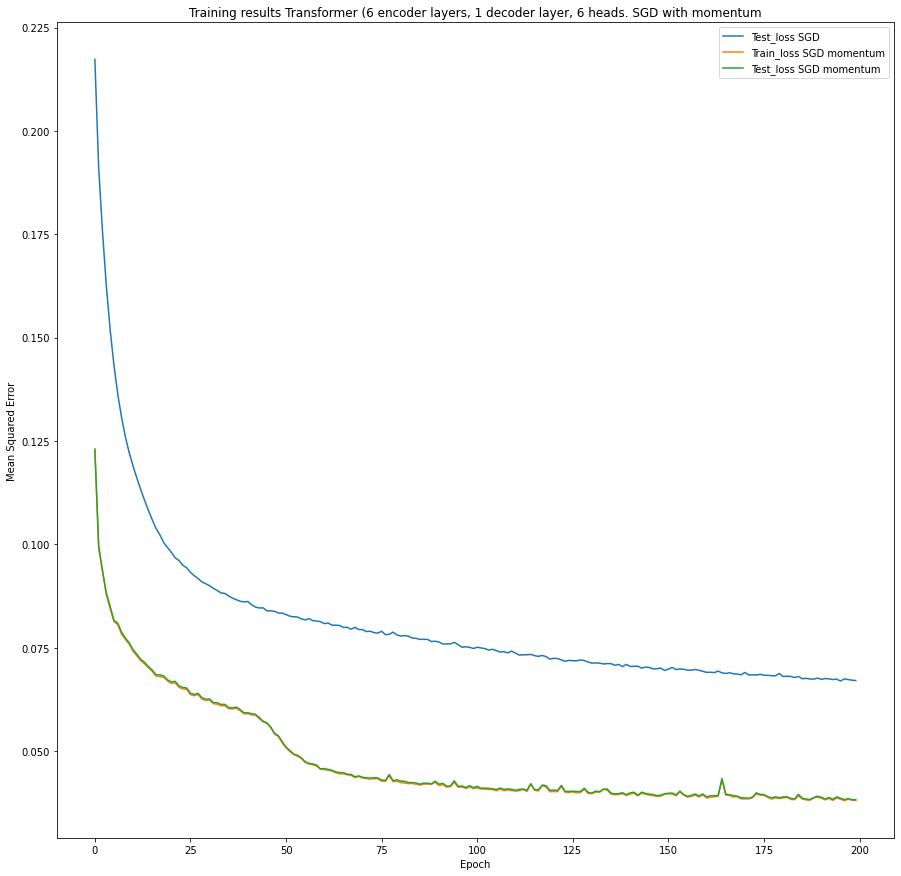

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss SGD')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss SGD momentum')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss SGD momentum')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# Train Transformer (New Hyperparameters (Smaller model))



In [ ]:
start_time = datetime.now()

# Initialize Transformer Model and Optimizer

continue_training = False

if continue_training is False:
  model_transformer_small = Transformer (num_encoder_layers=1,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=1,
                      dim_feedforward=512,
                      device = device,
                      batch_first=False)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer_small.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')


train_transformer = True

if train_transformer is True:
  trained_model_transformer_small, train_losses_4, test_losses_4 = training_transformer(
      model= model_transformer_small, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss SGD')

  ax.plot([np.mean(i) for i in train_losses_4], label= 'Train_loss smaller model')
  ax.plot([np.mean(i) for i in test_losses_4], label= 'Test_loss smaller model')
  ax.set_title("Training results Transformer (1 encoder layers, 1 decoder layer, 1 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

NameError: ignored

# Train Transformer (New Hyperparameters (Bigger model))


In [ ]:
start_time = datetime.now()

# Initialize Transformer Model and Optimizer

continue_training = False

if continue_training is False:
  model_transformer_big = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=False)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer_big.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')


train_transformer = True

if train_transformer is True:
  trained_model_transformer_big, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer_big, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss SGD')

  ax.plot([np.mean(i) for i in train_losses_5], label= 'Train_loss bigger model')
  ax.plot([np.mean(i) for i in test_losses_5], label= 'Test_loss bigger model')
  ax.set_title("Training results Transformer (10 encoder layers, 5 decoder layer, 9 heads. SGD")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# NEW APPROACH


In [198]:
def create_sequece_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    next = np.array(dataset_norm.iloc[i+30, 1:], dtype= float)
    target = np.array(dataset_norm.iloc[i+31, 1:], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=60,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=60,
      shuffle=True
  )

  return loader_train, loader_test

In [199]:
loader_train_seq, loader_test_seq = create_sequece_dataloaders_new(dataset_norm)

100%|██████████| 63300/63300 [00:39<00:00, 1619.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




In [200]:
class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)

    def positional_encoding(self, seq_len: int, dim_model: int, device):

        position_encoding = torch.zeros(seq_len, dim_model)

        for pos in range(seq_len):
          for i in range(0, int(dim_model / 2)):
            position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
            position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

        position_encoding = position_encoding.to(device)

        return position_encoding
        
    def forward (self, enc_input, dec_input):
        
        memory_mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + self.positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + self.positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src= src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=None, memory_mask=None)
        
        return output

In [201]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer, train_losses_1, test_losses_1 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 950/950 [00:19<00:00, 48.86it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.35it/s]



Current Mean loss Train Set:  0.44801645451470423

Test with test set


100%|██████████| 106/106 [00:00<00:00, 141.30it/s]



Current Mean loss Test Set:  0.45125759603842247


Epoch: 2 of 200
Training...


100%|██████████| 950/950 [00:19<00:00, 48.64it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 147.07it/s]



Current Mean loss Train Set:  0.42523674462970934

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.82it/s]



Current Mean loss Test Set:  0.427463302634797


Epoch: 3 of 200
Training...


100%|██████████| 950/950 [00:19<00:00, 47.70it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.19it/s]



Current Mean loss Train Set:  0.40854350504122283

Test with test set


100%|██████████| 106/106 [00:00<00:00, 147.15it/s]



Current Mean loss Test Set:  0.41231143334001863


Epoch: 4 of 200
Training...


100%|██████████| 950/950 [00:22<00:00, 43.08it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 112.10it/s]



Current Mean loss Train Set:  0.3958864596015529

Test with test set


100%|██████████| 106/106 [00:00<00:00, 129.47it/s]



Current Mean loss Test Set:  0.3995251214166857


Epoch: 5 of 200
Training...


100%|██████████| 950/950 [00:22<00:00, 42.12it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 108.67it/s]



Current Mean loss Train Set:  0.3841176486642737

Test with test set


100%|██████████| 106/106 [00:00<00:00, 118.89it/s]



Current Mean loss Test Set:  0.3882783148086296


Epoch: 6 of 200
Training...


100%|██████████| 950/950 [00:21<00:00, 45.05it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 115.28it/s]



Current Mean loss Train Set:  0.3744651185995654

Test with test set


100%|██████████| 106/106 [00:00<00:00, 123.08it/s]



Current Mean loss Test Set:  0.37860491253295037


Epoch: 7 of 200
Training...


 58%|█████▊    | 551/950 [00:11<00:07, 49.94it/s]